# Introduction to Image Convolution

1. dot product
2. dot product of 2D data
3. cross-correlation = a 2D result of dot products
4. convolution == 2D linear filter
    1. Smoothing
    1. Edge Detection: Sobel Operator
7. Nonlinear edge detection, Canny edge detector

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.rcParams["figure.figsize"] = (14, 4)

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## 1. Dot Product

$ a = x \cdot y $, $a \in \mathbb{R}$

## 2. dot product of 2D vectors

$
a = x \cdot y
$

## 3. Cross-Correlation (Convolution in CNN)

1. kernel matrix (2D)
2. source matrix (2D)
3. scan and dot product
4. construct output 2D image

## 4. Convolution as 2D linear filter

* Ref: https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html

1. Box filter for smoothing
$
    W = \frac{1}{9} [ [1, 1, 1], [1, 1, 1], [1, 1, 1]]  \in \mathbb{R}^2
$


2. A derivative filter for gradient approximation
$
    W = [ [-1, -2, 1], [0, 0, 0], [1, 2, 1]]  \in \mathbb{R}^2
$

$
    S = I * W
$

### PyTorch

- pytorch is aimed to compute the kernel parameters, but here we utilize its computation only. 
- No learning here.
- Channel - Depth - Row - Col

In [15]:
conv2d = nn.Conv2d(in_channels=1, 
                   out_channels=1, 
                   kernel_size=25, padding=25//2)
print(conv2d.weight.shape)
conv2d.weight.data[0,0,:2, :3]  # weights are random

torch.Size([1, 1, 25, 25])


tensor([[ 0.0276, -0.0140, -0.0124],
        [-0.0123,  0.0114,  0.0052]])

In [17]:
conv2d.weight[:,:,:2,:3]  # weight has gradient function attached for auto-gradient through a computation graphy.

tensor([[[[ 0.0276, -0.0140, -0.0124],
          [-0.0123,  0.0114,  0.0052]]]], grad_fn=<SliceBackward0>)

In [18]:
# copy the kernel into the weight of conv2d
for i in range(len(kernel)):
    for j in range(len(kernel[0])):
        conv2d.weight.data[0,0, i, j] = torch.tensor(kernel[i,j])

NameError: name 'kernel' is not defined

In [ ]:
conv2d.weight[:,:,:2,:3]

tensor([[[[0.0016, 0.0016, 0.0016],
          [0.0016, 0.0016, 0.0016]]]], grad_fn=<SliceBackward>)

In [ ]:
# Here, we consider 1 channel image only; multi channel image comes later
# batch x channel x height x width
batch_im = img[:,:,0].reshape(1, 1, img_size, img_size) 
batch_im = torch.FloatTensor(batch_im)
print(batch_im.shape, batch_im.dtype)

torch.Size([1, 1, 512, 512]) torch.float32


In [ ]:
# just check the output shape
with torch.no_grad():  # we do not gradient here
    convout = conv2d (batch_im)

print(convout.shape, convout.dtype)
convout_im = convout.numpy()
convout_im = convout_im.reshape(img_size, img_size)
plt.imshow(convout_im, cmap='gray');

torch.Size([1, 1, 512, 512]) torch.float32


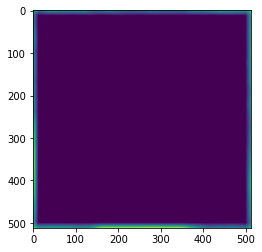

In [ ]:
diff = np.abs(smoothed[:,:,0] - convout_im)
plt.imshow(diff); #, cmap='gray');

- The same results except for the boundary pixels
- PyTorch is to learn the kernel parameters, not to perform a pre-defined convolution operation.
- How to learn? Through SGD.
    - Supervised learning.

### Sobel Operator

- Gradient computation

In [ ]:
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
im = hsv[:,:,2].astype(np.float32)  # image brightness only
plt.imshow(im, 'gray');

(512, 1)


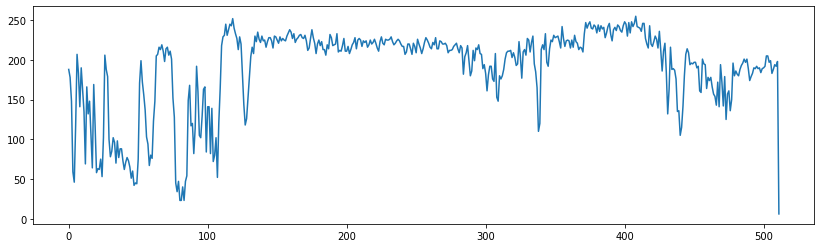

In [ ]:
iv = im[:,180:181]; print(ii.shape)
plt.plot(iv);

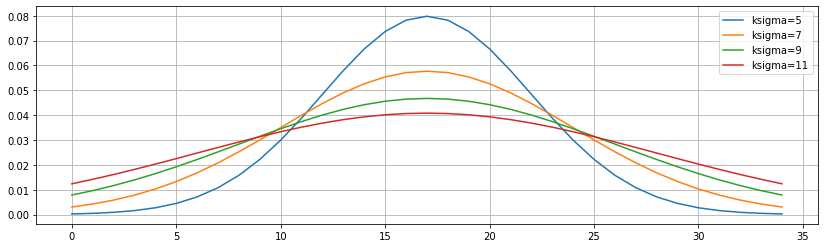

In [ ]:
gkernel = cv2.getGaussianKernel(ksize=31, sigma=9, ktype=cv2.CV_32F)
for ks in [5, 7, 9, 11]:
    gk = cv2.getGaussianKernel(ksize=35, sigma=ks, ktype=cv2.CV_32F)
    plt.plot(gk, label=f"ksigma={ks}");
plt.grid(True); plt.legend();

In [ ]:
print(gkernel.sum(), gkernel.shape)
gkernel = gkernel[:,0]
gkernel.shape

1.0 (31, 1)


(31,)

In [ ]:
ii = np.ones(200)
ii[:100] = 0
plt.plot(ii);

In [ ]:
ii = np.ones(200)
ii[:100] = 0
plt.plot(ii);
plt.plot(gkernel*10);

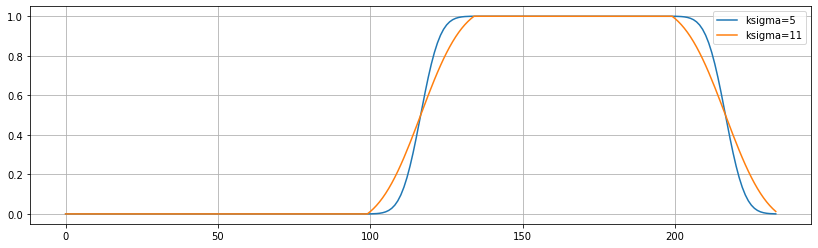

In [ ]:
# plt.plot(np.convolve(ii, gkernel)[:200])
for ks in [5, 11]:
    gk = cv2.getGaussianKernel(ksize=35, sigma=ks, ktype=cv2.CV_32F)
    conv = np.convolve(ii, gk[:,0])
    plt.plot(conv, label=f"ksigma={ks}");
plt.grid(True); plt.legend();

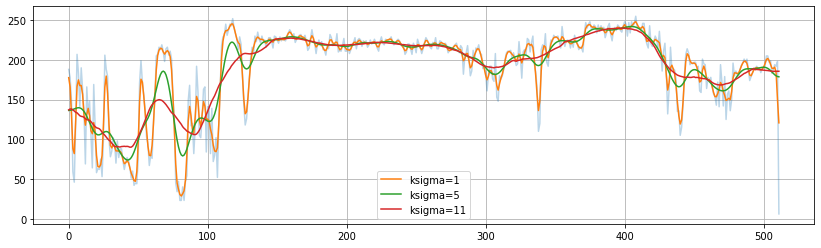

In [ ]:
plt.plot(iv, alpha=.3);
for ks in [1, 5, 11]:
    gk = cv2.getGaussianKernel(ksize=35, sigma=ks, ktype=cv2.CV_32F)
    conv = cv2.filter2D(iv, -1, gk)
    plt.plot(conv, label=f"ksigma={ks}");
plt.grid(True); plt.legend();

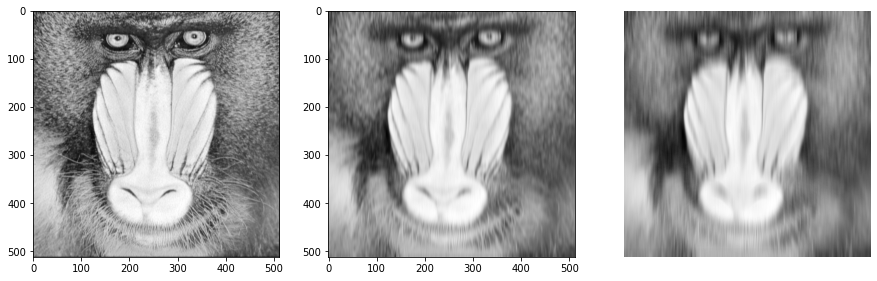

In [ ]:
imfiltered = []
for ks in [1, 5, 11]:
    gk = cv2.getGaussianKernel(ksize=35, sigma=ks, ktype=cv2.CV_32F)  # vertical smoothing filter
    conv = cv2.filter2D(im, -1, gk)
    imfiltered.append(conv)
fig, axes = plt.subplots(1,3,figsize=(15,5))
for ax, imf in zip(axes, imfiltered):
    ax.imshow(imf, cmap='gray')
ax.set_axis_off();

(31, 1) (31, 1)


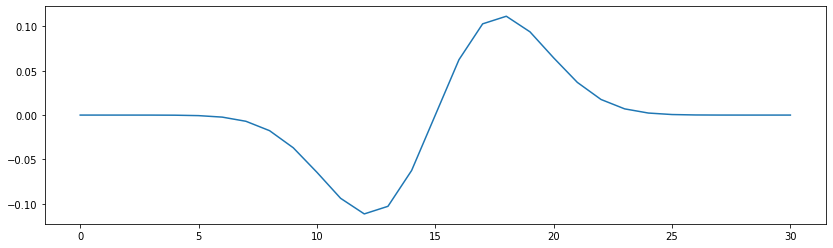

In [ ]:
kx, ky = cv2.getDerivKernels(dx=1, dy=0, ksize=31)
kx /= np.abs(kx).sum()
ky /= np.abs(ky).sum()
plt.plot(kx);
# plt.plot(ky)
print(kx.shape, ky.shape)

(512, 1) (512, 1) (5, 1) [-0.16666667 -0.33333334  0.          0.33333334  0.16666667]


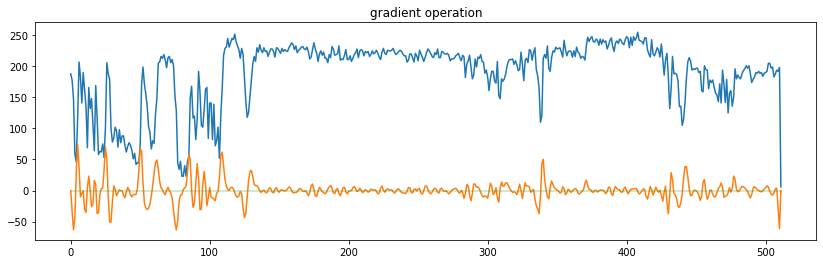

In [ ]:
kx, ky = cv2.getDerivKernels(dx=1, dy=0, ksize=5)
kx /= np.abs(kx).sum()

grad = cv2.filter2D(iv, -1, kx)

print(grad.shape, iv.shape, kx.shape, kx[:,0])
plt.plot(iv);
plt.plot(grad);
plt.plot([0]*iv.shape[0], alpha=.3)
plt.title('gradient operation');

In [ ]:
plt.plot(iv[:100]);
plt.plot(grad[:100]);
plt.plot([0]*100)
plt.title('gradient operation');

In [ ]:
plt.stem(iv[:100]);
plt.stem(grad[:100], markerfmt='ro');
plt.title('gradient operation');

(512, 1) (512, 1) (15, 1)
[-0.00029138 -0.0034965  -0.01893939 -0.06060606 -0.125      -0.16666667
 -0.125       0.          0.125       0.16666667  0.125       0.06060606
  0.01893939  0.0034965   0.00029138]


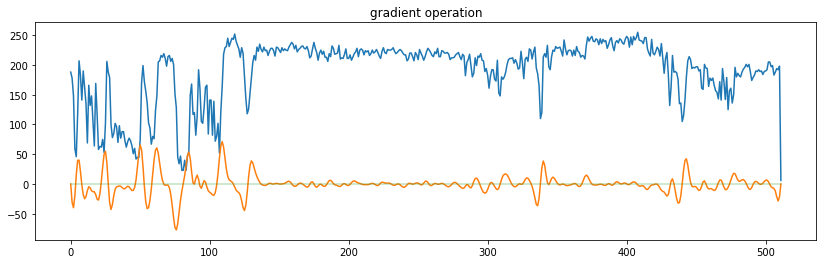

In [ ]:
kx, ky = cv2.getDerivKernels(dx=1, dy=0, ksize=15)
kx /= np.abs(kx).sum()

grad = cv2.filter2D(iv, -1, kx)

print(grad.shape, iv.shape, kx.shape)
print(kx[:,0])
plt.plot(iv);
plt.plot(grad);
plt.plot([0]*iv.shape[0], alpha=.3)
plt.title('gradient operation');

### Sobel operator

In [ ]:
im = cv2.imread("data/left01.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im, cmap='gray');

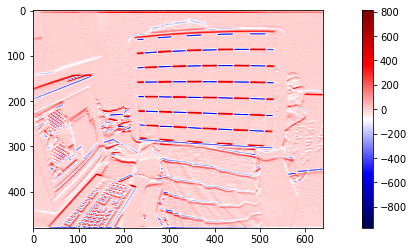

In [ ]:
kernel_y = np.array([ [-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
grad_y = cv2.filter2D(im.astype(np.float32), -1, kernel_y,)  #

plt.imshow(grad_y, cmap='seismic'); plt.colorbar();

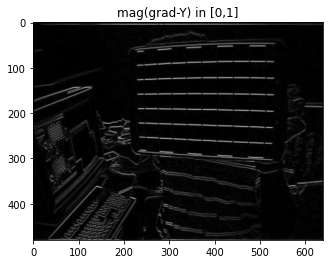

In [ ]:
gabsy = np.abs(grad_y)  # make positive
gabsy = gabsy / gabsy.max()  # scale to [0, 1]

plt.imshow(gabsy, cmap='gray'); plt.title("mag(grad-Y) in [0,1]");

In [ ]:
grad_y.min(), grad_y.max()+1

(-972.0, 812.0)

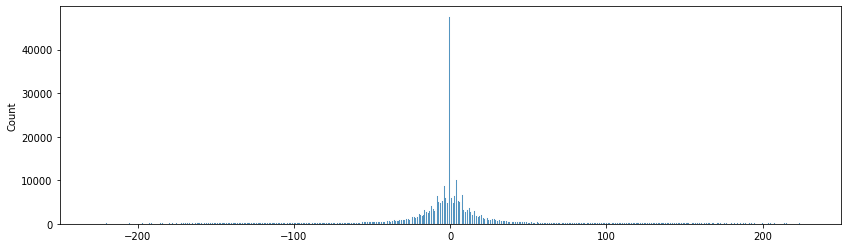

In [ ]:
ax = sns.histplot(grad_y.reshape(-1),);
ax.set_xlim(-250, 250);

In [ ]:
kernel_x = kernel_y.T  # x direction
grad_x = cv2.filter2D(im.astype(np.float32), -1, kernel_x)  # applies conv2d to each channel & combine
print(grad_x.shape, grad_x.min(), grad_x.max())
gabsx = np.abs(grad_x)
gabsx = gabsx / gabsx.max()
plt.imshow(gabsx, cmap='gray');

(480, 640) -852.0 842.0


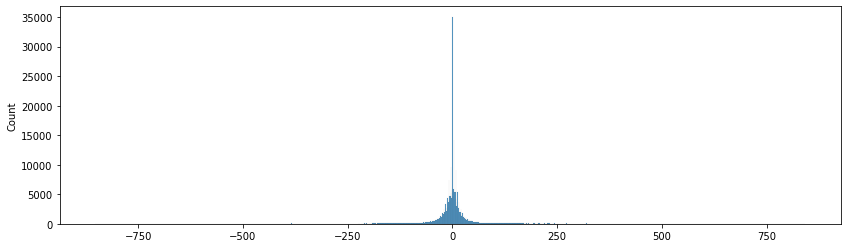

In [ ]:
sns.histplot(grad_x.reshape(-1), discrete=True);

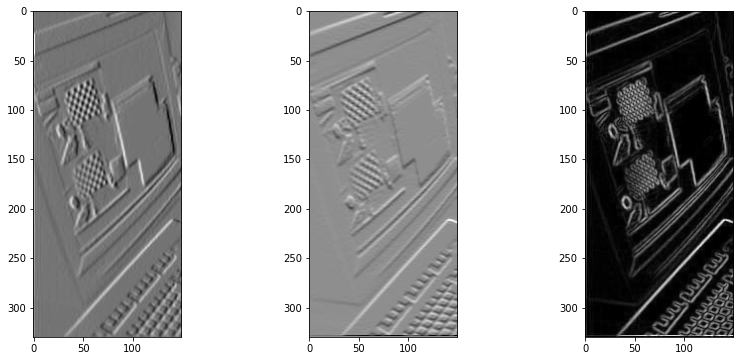

In [ ]:
gabs = gabsx + gabsy 

fig, axes = plt.subplots(1,3, figsize=(14,6))
for ax, im in zip(axes, [grad_x, grad_y, gabs]):
    ax.imshow(im[150:, :150], cmap='gray')
    ax.set(title='')

# Sobel Operator

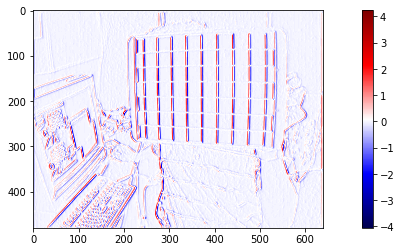

In [ ]:
grad_x = cv2.Sobel(im, -1, 1, 0, ksize=3)

plt.imshow(grad_x, cmap="seismic"); plt.colorbar();

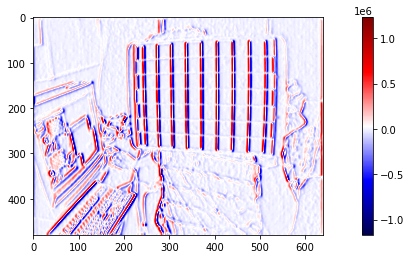

In [ ]:
grad_x = cv2.Sobel(im, -1, 1, 0, ksize=13)

plt.imshow(grad_x, cmap="seismic"); plt.colorbar();

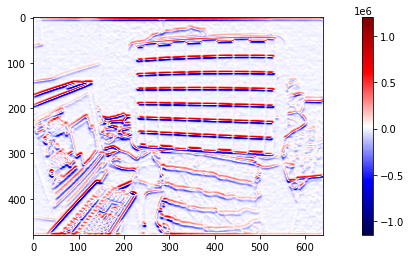

In [ ]:
grad_y = cv2.Sobel(im, -1, 0, 1, ksize=13)

plt.imshow(grad_y, cmap="seismic"); plt.colorbar();

In [ ]:
sns.histplot(grad_y.ravel());

KeyboardInterrupt: 

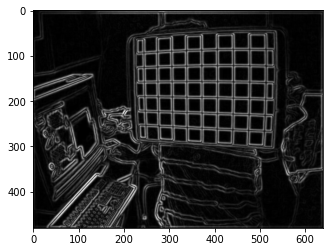

In [ ]:
grad_mag = np.abs(grad_x) + np.abs(grad_y)
plt.imshow(grad_mag, cmap='gray'); 

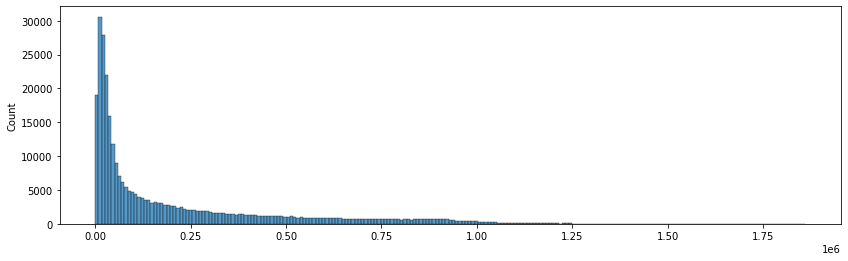

In [ ]:
sns.histplot(grad_mag.reshape(-1));

In [ ]:
grad_x = cv2.Sobel(im, -1, 1, 0, ksize=3)
grad_y = cv2.Sobel(im, -1, 0, 1, ksize=3)

grad_mag = np.abs(grad_x) + np.abs(grad_y)
plt.imshow(grad_mag, cmap='gray'); 

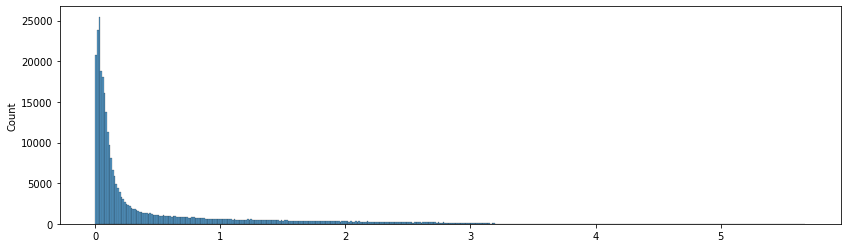

In [ ]:
sns.histplot(grad_mag.reshape(-1));

## Canny Operator
- Ref: https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

- Edge map generation algorithm
    - binary edge map of single pixel width

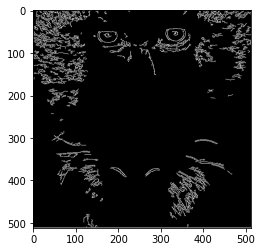

In [ ]:
lowerTh = 200
edge_canny = cv2.Canny(img[:,:,0], threshold1=lowerTh, threshold2=3*lowerTh) # red channel
plt.imshow(edge_canny, cmap="gray");

## Multi-Channel Convolution by Pytorch Conv2d

- Up to now, convolution kernel is of shape $H\times W$
- In CNN, a conv kernel in general is of shape $C\times H \times W$

In [ ]:
conv2d = nn.Conv2d(in_channels=3, # input source is of 3 channel (eg. RGB or HSV); it can be of N >= 1 channel.
                   out_channels=1, # We define only one 3xHxW conv. kernel
                   kernel_size=25, # H & W
                   padding=25//2   # to keep the output shape the same as input
                   )
print(conv2d.weight.shape)
conv2d.weight.data[0,0,:2, :3]  # some of the weights

torch.Size([1, 3, 25, 25])


tensor([[ 0.0129,  0.0106, -0.0090],
        [ 0.0227,  0.0131, -0.0189]])

In [ ]:
# copy the kernel into the weight of conv2d
wn = conv2d.weight.shape[1]*conv2d.weight.shape[2]*conv2d.weight.shape[3]
print('weight normalization factor: ', wn)

for c in range(3):
    for i in range(25):
        for j in range(25):
            conv2d.weight.data[0,c, i, j] = torch.tensor(1./wn)

weight normalization factor:  1875


In [ ]:
conv2d.weight[:,:,:2,:3]

tensor([[[[0.0005, 0.0005, 0.0005],
          [0.0005, 0.0005, 0.0005]],

         [[0.0005, 0.0005, 0.0005],
          [0.0005, 0.0005, 0.0005]],

         [[0.0005, 0.0005, 0.0005],
          [0.0005, 0.0005, 0.0005]]]], grad_fn=<SliceBackward>)

In [ ]:
# Here, we consider 1 channel image only; multi channel image comes later
# batch x channel x height x width
im_in = img.copy()
print(im_in.shape)
batch_im = torch.tensor(im_in,dtype=torch.float32)
batch_im = batch_im.unsqueeze(0)       # HWC -> BHWC
print(batch_im.shape, batch_im.dtype)  # BHWC
batch_im = batch_im.permute(0,3,1,2)
print(batch_im.shape, batch_im.dtype)  # BCHW
batch_im /= 255.                       # better convergence and numerical stability

(512, 512, 3)
torch.Size([1, 512, 512, 3]) torch.float32
torch.Size([1, 3, 512, 512]) torch.float32


torch.Size([1, 1, 512, 512]) torch.float32


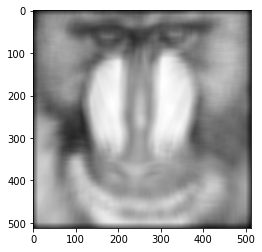

In [ ]:
# just check the output shape
with torch.no_grad():  # we do not gradient here
    convout = conv2d (batch_im)

print(convout.shape, convout.dtype)
convout_im = convout.numpy()
convout_im = convout_im.reshape(img_size, img_size)
plt.imshow(convout_im, cmap='gray');

In [ ]:
import torchvision
toTensor = torchvision.transforms.ToTensor()
im_t = toTensor(im_in)
print('after toTensor(): ', im_t.shape)

after toTensor():  torch.Size([3, 512, 512])


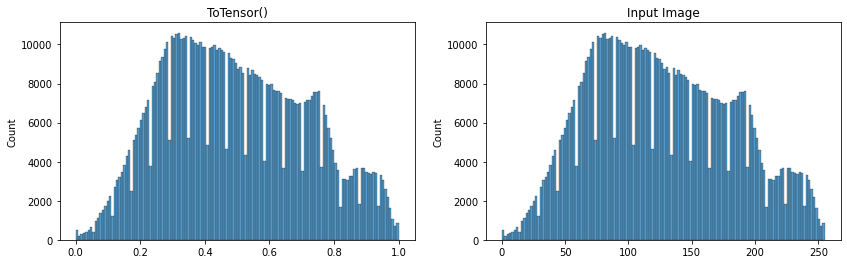

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(14,4))
sns.histplot(im_t.numpy().reshape(-1), ax=axes[0]); axes[0].set(title='ToTensor()')
sns.histplot(im_in.reshape(-1), ax=axes[1]); axes[1].set(title='Input Image');

torch.Size([1, 3, 512, 512])
conv out: torch.Size([1, 1, 512, 512])


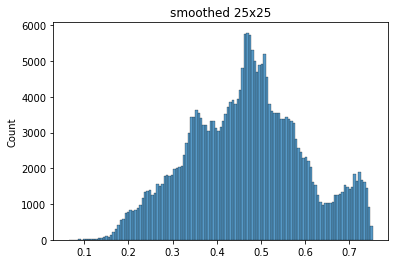

In [ ]:
im_t = im_t.unsqueeze(0); print(im_t.shape)
with torch.no_grad():
    sm_t = conv2d(im_t)
    print('conv out:', sm_t.shape)

ax = sns.histplot(sm_t.numpy().reshape(-1)); ax.set(title='smoothed 25x25');

---
# Filtering: Gaussian, Median, Bilateral
* See: https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html


In [ ]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [ ]:
## getGaussianKernel()
kernel_sizes = [3, 7, 11, 15, 21]
fig, axes = plt.subplots(1, len(kernel_sizes), figsize=(3*len(kernel_sizes), 3))
for ksize, ax in zip(kernel_sizes, axes):
    gkernel = cv2.getGaussianKernel(ksize, sigma=0)
    ax.plot(gkernel, '-o')

---
# Assignment: Image Convolution for smoothing:
1. A $3\times 21$ filter for horizontal blurring.
2. A $21\times 3$ filter for vertical blurring.
3. A $21\times 21$ filter for blurring in diagonal direction: what is the kernel form?

# Assignment: Learning a smoothing filter

1. Use random initialization for `torch.conv2d(filter_size=25, in_channels=1, out_channels=1);` meaning that you don't change the weight.
2. Compute three pairs of `(im, smoothed)` from each of RGB channels. This gives us 3 data points.
3. Train the network so that the output of `conv2d` may produce the box filter.
1. `MSELoss()` or `L1Loss` can be used. When `(smoothed, predicted)` pair is supplied to the loss function, get rid of the boundary pixsels (even though you may use them all) because they do not belong to the pixels of main computation.

4. Can you do the same thing for Canny edge detection?

---

# Gabor Filters
- G(x; $\theta$) = Gaussian(x) * Sin(x) in 2D
- [Gabor filter in Wikipedia.com](https://en.wikipedia.org/wiki/Gabor_filter#:~:text=In%20image%20processing%2C%20a%20Gabor,point%20or%20region%20of%20analysis.)
    - In image processing, a Gabor filter, named after Dennis Gabor, is a linear filter used for texture analysis, which essentially means that it analyzes whether there is any specific frequency content in the image in specific directions in a localized region around the point or region of analysis.

- [Gabor Filter in medium.com](https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97)
    
- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html
- `gabor_threads.py`
    - use of multiple Gabor filter convolutions to get Fractalius-like image effect (http://www.redfieldplugins.com/filterFractalius.htm)

In [ ]:
import cv2 
import numpy as np 
import gabor_threads  # gabor_threads.py in this folder
gfilters = gabor_threads.build_filters()
len(gfilters), gfilters[0].shape

(16, (31, 31))

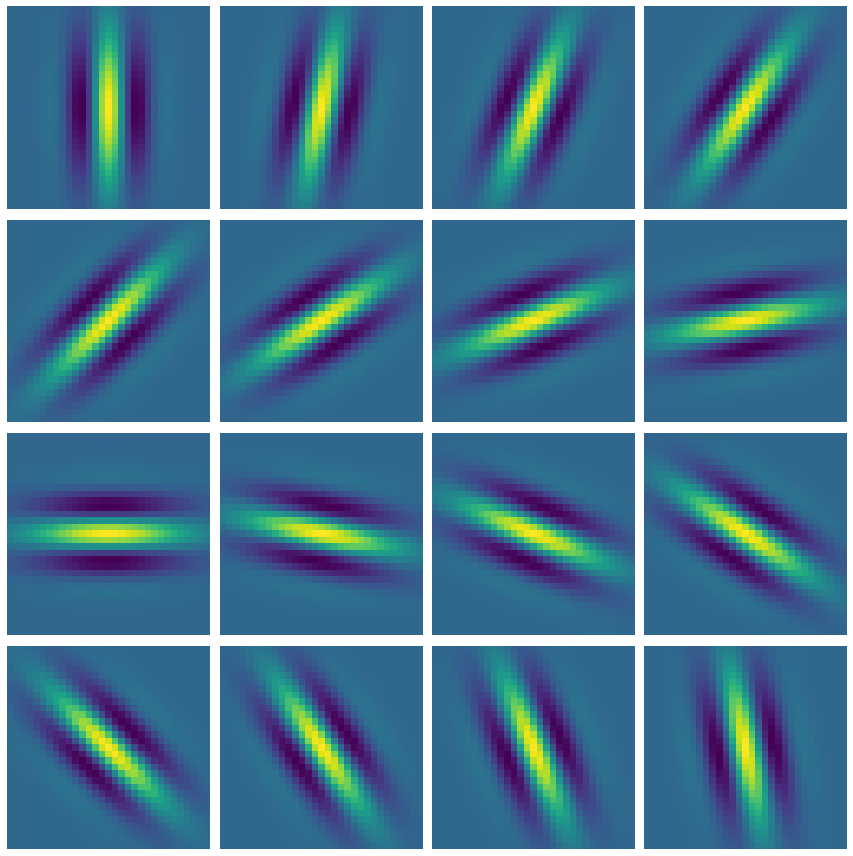

In [ ]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(4,4, figsize=(12,12))
for ax, gkernel in zip(axes.ravel(), gfilters):
    ax.imshow(gkernel); ax.set_axis_off();
fig.tight_layout()

In [ ]:
gk0 = gfilters[0] # the first filter
plt.plot(gk0[16,:], '-o'); plt.title('Gabor Filter Kernel');
# plt.plot(gk0[8, :], 'r-')
# plt.plot(gk0[4, :], 'g-')
gk0.sum(), np.linalg.norm(gk0)

(8.106758, 7.074621)

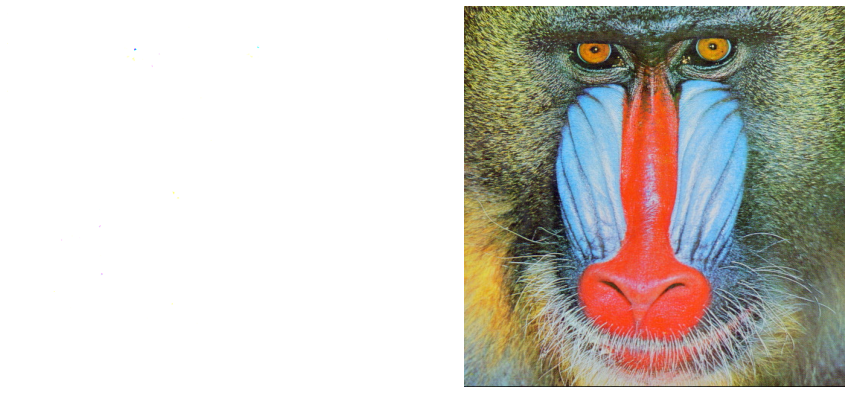

In [ ]:
img = cv2.imread('./pixels/baboon.jpg')[:,:,::-1]  # RGB
res1 = gabor_threads.process(img, gfilters)

fig, axes = plt.subplots(1,2, figsize=(15,10))
axes[0].imshow(res1); axes[1].imshow(img); axes[0].set_axis_off(); axes[1].set_axis_off();

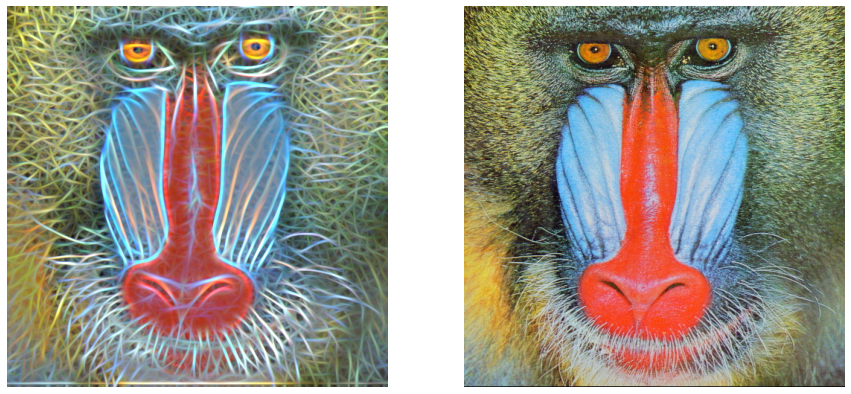

In [ ]:
img = cv2.imread('./pixels/baboon.jpg')[:,:,::-1]  # RGB
res1 = gabor_threads.process(img, gfilters)

fig, axes = plt.subplots(1,2, figsize=(15,10))
axes[0].imshow(res1); axes[1].imshow(img); axes[0].set_axis_off(); axes[1].set_axis_off();

In [ ]:
res1.min(), res1.max()

(0, 255)

In [ ]:
img2 = cv2.imread('./pixels/road-1072821_1280.jpg')[:,:,::-1]  # RGB

res2 = gabor_threads.process(img2, gfilters)

fig, axes = plt.subplots(2, 1, figsize=(13,15))
axes[0].imshow(res2); 
axes[1].imshow(img2); axes[0].set_axis_off(); axes[1].set_axis_off();
fig.tight_layout()

In [ ]:
img = cv2.imread('./pixels/baboon.jpg')[:,:,::-1]  # RGB

r, rlist = gabor_threads.process(img, gfilters, return_all=True)

fig, axes = plt.subplots(2, 4, figsize=(16,8))
for i in range(4):
    axes[0,i].imshow(gfilters[i*4]); 
    axes[1,i].imshow(rlist[i*4])
    #ax.set_axis_off();
fig.tight_layout()

In [ ]:
for res in rlist:
    print(res.min(), res.max())

0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
0 255
